# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math

import torch
from plaid.datasets import CATHShardedDataModule
from plaid.esmfold.misc import batch_encode_sequences

# Datasets

In [79]:
shard_dir = "/data/lux70/data/rocklin/shards/"
# embedder = "esmfold"
embedder = "esm2_t6_8M_UR50D"
D = 1024 if embedder == "esmfold" else 320

dm = CATHShardedDataModule(
    storage_type="hdf5",
    shard_dir=shard_dir,
    embedder=embedder,
    seq_len=256,
    batch_size=512
)
dm.setup()
train_dataloader = dm.train_dataloader()
val_dataloader = dm.val_dataloader()

# Model

In [80]:
import torch
from torch import nn, einsum
import torch.nn.functional as F
from einops import rearrange, reduce, repeat

# helpers

def exists(val):
    return val is not None

def default(val, d):
    return val if exists(val) else d

def pad_to_multiple(tensor, multiple, dim = -1, value = 0):
    seq_len = tensor.shape[dim]
    m = seq_len / multiple
    if m.is_integer():
        return tensor
    remainder = math.ceil(m) * multiple - seq_len
    pad_offset = (0,) * (-1 - dim) * 2
    return F.pad(tensor, (*pad_offset, 0, remainder), value = value)

def cast_tuple(val, depth = 1):
    return val if isinstance(val, tuple) else ((val,) * depth)

# factory

def get_hourglass_transformer(
    dim,
    *,
    depth,
    shorten_factor,
    attn_resampling,
    updown_sample_type,
    **kwargs
):
    assert isinstance(depth, int) or (isinstance(depth, tuple)  and len(depth) == 3), 'depth must be either an integer or a tuple of 3, indicating (pre_transformer_depth, <nested-hour-glass-config>, post_transformer_depth)'
    assert not (isinstance(depth, int) and shorten_factor), 'there does not need to be a shortening factor when only a single transformer block is indicated (depth of one integer value)'

    if isinstance(depth, int):
        return Transformer(dim = dim, depth = depth, **kwargs)

    return HourglassTransformer(dim = dim, depth = depth, shorten_factor = shorten_factor, attn_resampling = attn_resampling, updown_sample_type = updown_sample_type, **kwargs)

# up and down sample classes

class NaiveDownsample(nn.Module):
    def __init__(self, shorten_factor):
        super().__init__()
        self.shorten_factor = shorten_factor

    def forward(self, x):
        return reduce(x, 'b (n s) d -> b n d', 'mean', s = self.shorten_factor)

class NaiveUpsample(nn.Module):
    def __init__(self, shorten_factor):
        super().__init__()
        self.shorten_factor = shorten_factor

    def forward(self, x):
        return repeat(x, 'b n d -> b (n s) d', s = self.shorten_factor)

class LinearDownsample(nn.Module):
    def __init__(self, dim, shorten_factor):
        super().__init__()
        self.proj = nn.Linear(dim * shorten_factor, dim)
        self.shorten_factor = shorten_factor

    def forward(self, x):
        x = rearrange(x, 'b (n s) d -> b n (s d)', s = self.shorten_factor)
        return self.proj(x)

class LinearUpsample(nn.Module):
    def __init__(self, dim, shorten_factor):
        super().__init__()
        self.proj = nn.Linear(dim, dim * shorten_factor)
        self.shorten_factor = shorten_factor

    def forward(self, x):
        x = self.proj(x)
        return rearrange(x, 'b n (s d) -> b (n s) d', s = self.shorten_factor)

# classes

class PreNormResidual(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs) + x

class Attention(nn.Module):
    def __init__(
        self,
        dim,
        heads = 8,
        dim_head = 64,
        dropout = 0.,
        causal = False
    ):
        super().__init__()
        self.heads = heads
        self.causal = causal
        self.scale = dim_head ** -0.5
        inner_dim = heads * dim_head

        self.to_q = nn.Linear(dim, inner_dim, bias = False)
        self.to_kv = nn.Linear(dim, inner_dim * 2, bias = False)
        self.to_out = nn.Linear(inner_dim, dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, context = None, mask = None):
        h, device = self.heads, x.device
        kv_input = default(context, x)

        q, k, v = self.to_q(x), *self.to_kv(kv_input).chunk(2, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), (q, k, v))

        q = q * self.scale

        sim = einsum('b h i d, b h j d -> b h i j', q, k)
        mask_value = -torch.finfo(sim.dtype).max

        if exists(mask):
            mask = rearrange(mask, 'b j -> b () () j')
            sim = sim.masked_fill(~mask, mask_value)

        if self.causal:
            i, j = sim.shape[-2:]
            mask = torch.ones(i, j, device = device, dtype = torch.bool).triu_(j - i + 1)
            mask = rearrange(mask, 'i j -> () () i j')
            sim = sim.masked_fill(mask, mask_value)

        attn = sim.softmax(dim = -1)
        attn = self.dropout(attn)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)', h = h)
        return self.to_out(out)

def FeedForward(dim, mult = 4, dropout = 0.):
    return nn.Sequential(
        nn.Linear(dim, dim * mult),
        nn.GELU(),
        nn.Dropout(dropout),
        nn.Linear(dim * mult, dim)
    )

# transformer classes

class Transformer(nn.Module):
    def __init__(
        self,
        dim,
        *,
        depth,
        causal = False,
        heads = 8,
        dim_head = 64,
        attn_dropout = 0.,
        ff_mult = 4,
        ff_dropout = 0.,
        norm_out = False
    ):
        super().__init__()
        self.layers = nn.ModuleList([])

        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNormResidual(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = attn_dropout, causal = causal)),
                PreNormResidual(dim, FeedForward(dim, mult = ff_mult, dropout = ff_dropout))
            ]))

        self.norm = nn.LayerNorm(dim) if norm_out else nn.Identity()

    def forward(self, x, context = None, mask = None):
        for attn, ff in self.layers:
            x = attn(x, context = context, mask = mask)
            x = ff(x)

        return self.norm(x)

class HourglassTransformer(nn.Module):
    def __init__(
        self,
        dim,
        *,
        depth,
        shorten_factor = 2,
        attn_resampling = True,
        updown_sample_type = 'naive',
        heads = 8,
        dim_head = 64,
        causal = False,
        norm_out = False
    ):
        super().__init__()
        assert len(depth) == 3, 'depth should be a tuple of length 3'
        assert updown_sample_type in {'naive', 'linear'}, 'downsample / upsample type must be either naive (average pool and repeat) or linear (linear projection and reshape)'

        pre_layers_depth, valley_depth, post_layers_depth = depth

        if isinstance(shorten_factor, (tuple, list)):
            shorten_factor, *rest_shorten_factor = shorten_factor
        elif isinstance(valley_depth, int):
            shorten_factor, rest_shorten_factor = shorten_factor, None
        else:
            shorten_factor, rest_shorten_factor = shorten_factor, shorten_factor

        transformer_kwargs = dict(
            dim = dim,
            heads = heads,
            dim_head = dim_head
        )

        self.causal = causal
        self.shorten_factor = shorten_factor

        if updown_sample_type == 'naive':
            self.downsample = NaiveDownsample(shorten_factor)
            self.upsample   = NaiveUpsample(shorten_factor)
        elif updown_sample_type == 'linear':
            self.downsample = LinearDownsample(dim, shorten_factor)
            self.upsample   = LinearUpsample(dim, shorten_factor)
        else:
            raise ValueError(f'unknown updown_sample_type keyword value - must be either naive or linear for now')

        self.valley_transformer = get_hourglass_transformer(
            shorten_factor = rest_shorten_factor,
            depth = valley_depth,
            attn_resampling = attn_resampling,
            updown_sample_type = updown_sample_type,
            causal = causal,
            **transformer_kwargs
        )

        self.attn_resampling_pre_valley = Transformer(depth = 1, **transformer_kwargs) if attn_resampling else None
        self.attn_resampling_post_valley = Transformer(depth = 1, **transformer_kwargs) if attn_resampling else None

        self.pre_transformer = Transformer(depth = pre_layers_depth, causal = causal, **transformer_kwargs)
        self.post_transformer = Transformer(depth = post_layers_depth, causal = causal, **transformer_kwargs)
        self.norm_out = nn.LayerNorm(dim) if norm_out else nn.Identity()

    def forward(self, x, mask = None):
        # b : batch, n : sequence length, d : feature dimension, s : shortening factor

        s, b, n = self.shorten_factor, *x.shape[:2]

        # top half of hourglass, pre-transformer layers

        x = self.pre_transformer(x, mask = mask)

        # pad to multiple of shortening factor, in preparation for pooling

        x = pad_to_multiple(x, s, dim = -2)

        if exists(mask):
            padded_mask = pad_to_multiple(mask, s, dim = -1, value = False)

        # save the residual, and for "attention resampling" at downsample and upsample

        x_residual = x.clone()

        # if autoregressive, do the shift by shortening factor minus one

        if self.causal:
            shift = s - 1
            x = F.pad(x, (0, 0, shift, -shift), value = 0.)

            if exists(mask):
                padded_mask = F.pad(padded_mask, (shift, -shift), value = False)

        # naive average pool

        downsampled = self.downsample(x)

        if exists(mask):
            downsampled_mask = reduce(padded_mask, 'b (n s) -> b n', 'sum', s = s) > 0
        else:
            downsampled_mask = None

        # pre-valley "attention resampling" - they have the pooled token in each bucket attend to the tokens pre-pooled

        if exists(self.attn_resampling_pre_valley):
            if exists(mask):
                attn_resampling_mask = rearrange(padded_mask, 'b (n s) -> (b n) s', s = s)
            else:
                attn_resampling_mask = None

            downsampled = self.attn_resampling_pre_valley(
                rearrange(downsampled, 'b n d -> (b n) () d'),
                rearrange(x, 'b (n s) d -> (b n) s d', s = s),
                mask = attn_resampling_mask
            )

            downsampled = rearrange(downsampled, '(b n) () d -> b n d', b = b)

        # the "valley" - either a regular transformer or another hourglass

        x = self.valley_transformer(downsampled, mask = downsampled_mask)

        valley_out = x.clone()

        # naive repeat upsample

        x = self.upsample(x)

        # add the residual

        x = x + x_residual

        # post-valley "attention resampling"

        if exists(self.attn_resampling_post_valley):
            x = self.attn_resampling_post_valley(
                rearrange(x, 'b (n s) d -> (b n) s d', s = s),
                rearrange(valley_out, 'b n d -> (b n) () d')
            )

            x = rearrange(x, '(b n) s d -> b (n s) d', b = b)

        # bring sequence back to original length, if it were padded for pooling

        x = x[:, :n]

        # post-valley transformers

        x = self.post_transformer(x, mask = mask)
        return self.norm_out(x)

transformer = get_hourglass_transformer(
    dim = D,                     # feature dimension
    heads = 8,                      # attention heads
    dim_head = 64,                  # dimension per attention head
    shorten_factor = 2,             # shortening factor
    depth = (4, 2, 4),              # tuple of 3, standing for pre-transformer-layers, valley-transformer-layers (after downsample), post-transformer-layers (after upsample) - the valley transformer layers can be yet another nested tuple, in which case it will shorten again recursively
    attn_resampling = True,
    updown_sample_type = "naive",
    causal = True,
    norm_out = True
)

# Train

## Sample Batch

In [81]:
batch = next(iter(train_dataloader))

sequences = batch[1]
tokens, mask, _, _, _ = batch_encode_sequences(sequences)

x = batch[0]
if embedder != "esmfold":
    x = x[:, 1:-1, :]
mask = mask.bool()
print(x.shape)
print(mask.shape)

device = "cuda"
transformer = transformer.to(device)
x, mask = x.to(device), mask.to(device)

torch.Size([512, 43, 320])
torch.Size([512, 43])


In [82]:
output = transformer(x, mask)

In [83]:
output.shape

torch.Size([512, 43, 320])

## Train Loop

In [88]:
from tqdm.notebook import tqdm, trange
import torch.nn.functional as F
from torch.optim import AdamW

optimizer = AdamW(transformer.parameters(), lr=1e-4)
n_epochs = 500

losses = []

for epoch in trange(n_epochs): 
    for i, batch in enumerate(train_dataloader):
        sequences = batch[1]
        tokens, mask, _, _, _ = batch_encode_sequences(sequences)

        x = batch[0]
        if embedder != "esmfold":
            x = x[:, 1:-1, :]
        mask = mask.bool()
        x, mask = x.to(device), mask.to(device)
        
        # noise = torch.randn_like(x)
        # x_noised = x + noise
        # output = transformer(x_noised, mask)
        output = transformer(x, mask)
        loss = F.mse_loss(x, output)
        losses.append(loss.item())
        if i % 50 == 0: print(loss.item()) 
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

  0%|          | 0/500 [00:00<?, ?it/s]

0.035845961421728134
0.033326685428619385
0.031069863587617874
0.029672497883439064
0.028546307235956192
0.02752477489411831
0.026572855189442635
0.025748198851943016
0.02485238015651703
0.024377355352044106
0.023246990516781807
0.022477811202406883
0.021738136187195778
0.02120210975408554
0.02036917395889759
0.019934097304940224
0.0191204734146595
0.01850868947803974
0.01789453998208046
0.017309917137026787
0.01691448874771595
0.016384942457079887
0.015899430960416794
0.01532022561877966
0.014860481023788452
0.014414000324904919
0.014095748774707317
0.013452598825097084
0.013421254232525826
0.012859363108873367
0.01231471449136734
0.011976531706750393
0.011537332087755203
0.011355330236256123
0.010985419154167175
0.010843458585441113
0.010638715699315071
0.010002760216593742
0.009749649092555046
0.009461858309805393
0.009264327585697174
0.009261995553970337
0.008769209496676922
0.00890357792377472
0.008274618536233902
0.00820575188845396
0.00798237044364214
0.007679465226829052
0.0075

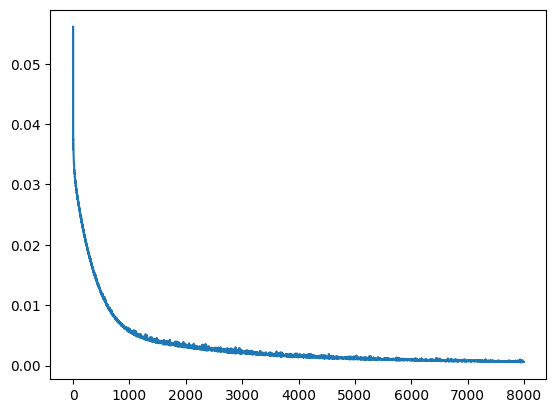

In [89]:
import matplotlib.pyplot as plt
plt.plot(losses)